In [1898]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

from cryo_sbi.wpa_simulator.image_generation import gen_quat

In [1899]:
model_idx = 10

In [1900]:
image_params = {
                'N_PIXELS': 128,
                'PIXEL_SIZE': 1.5,
                'SIGMA': 4.0,
                'ROTATIONS': True,
                'SHIFT': True,
                'CTF': True,
                'NOISE': True,
                'DEFOCUS': 1.5,
                'SNR': 0.1,
                'RADIUS_MASK': 64,
                'AMP': 0.1,
                'B_FACTOR': 1,
                'ELECWAVE': 0.019866
}

In [1901]:
coord = np.load("../data/protein_models/hsp90_models.npy")[model_idx]

In [1902]:
coords = []
centers = []
for i in range(3):
    coord = np.load("../data/protein_models/hsp90_models.npy")[:, 0][10]
    rot_mat = Rotation.from_quat(gen_quat()).as_matrix()
    coord = np.matmul(rot_mat, coord)

    if i > 0:
        r = np.random.uniform(low=50, high=180)
        phi = np.random.uniform(low=0, high=2*np.pi)
        coord += np.array([r*np.cos(phi), r*np.sin(phi), 0]).reshape(-1, 1)
        centers.append((r*np.cos(phi), r*np.sin(phi)))
    
    coords.append(coord)
coord = np.concatenate(coords, axis=1)

## Rotate structure

In [1903]:
#quat = np.array([-0.76882173,  0.21902341, -0.3074588 ,  0.51615015])
#rot_mat = Rotation.from_quat(quat).as_matrix()
#coord = np.matmul(rot_mat, coord)

## Generating the projection

In [1904]:
margin_ratio = 1
def gen_img(coord, image_params):

    n_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * image_params["SIGMA"] ** 2 * n_atoms)

    extra_pixel = round(image_params["N_PIXELS"] * margin_ratio)
    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] + extra_pixel - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] + extra_pixel - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = torch.arange(grid_min, grid_max, image_params["PIXEL_SIZE"])

    gauss_x = torch.exp(
        -0.5 * (((grid[:, None] - coord[0, :]) / image_params["SIGMA"]) ** 2)
    )

    gauss_y = torch.exp(
        -0.5 * (((grid[:, None] - coord[1, :]) / image_params["SIGMA"]) ** 2)
    )

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image, grid

torch.Size([256, 256])


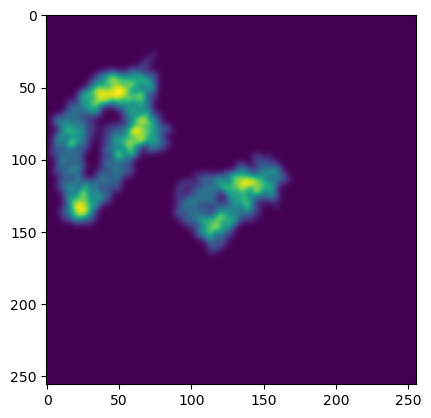

In [1905]:
image_clear, grid = gen_img(coord, image_params)
print(image_clear.shape)
plt.imshow(image_clear)

## Add padding for shift

In [1906]:
from torch.nn import ConstantPad2d
def pad_image(image, image_params):

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1
    
    padder = ConstantPad2d(pad_width, 0.0)

    padded_image = padder(image)

    return padded_image

## Calculate and add the ctf

In [1907]:
def calc_ctf(image_params):

    # Attention look into def pad_image function to know the image size after padding 
    extra_pixel = round(image_params["N_PIXELS"] * margin_ratio) #2 * ( int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1) + image_params["N_PIXELS"]
    image_size = image_params["N_PIXELS"] + extra_pixel
    freq_pix_1d = torch.fft.fftfreq(
        image_size,
        d=image_params["PIXEL_SIZE"]
    )

    if isinstance(image_params["DEFOCUS"], float):
        phase = image_params["DEFOCUS"] * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    elif isinstance(image_params["DEFOCUS"], list) and len(image_params["DEFOCUS"]) == 2:
        defocus = np.random.uniform(low=image_params["DEFOCUS"][0], high=image_params["DEFOCUS"][1])
        phase = defocus * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    else:
        raise ValueError("Defocus should be a single value or a list of [min_defocus, max_defocus]")

    x, y = torch.meshgrid(freq_pix_1d, freq_pix_1d)

    freq2_2d = x**2 + y**2
    imag = torch.zeros_like(freq2_2d) * 1j

    env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
    ctf = (
        image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
        - torch.tensor(1 - image_params["AMP"]**2).sqrt()
        * torch.tensor(phase * freq2_2d * 0.5).sin()
        + imag
    )
    return ctf * env / image_params["AMP"]


def apply_ctf(image, ctf):

    conv_image_ctf = torch.fft.fft2(image) * ctf.real

    image_ctf = torch.fft.ifft2(conv_image_ctf).real

    return image_ctf

In [1908]:
ctf = calc_ctf(image_params)
image_ctf = apply_ctf(image_clear, calc_ctf(image_params))

/tmp/ipykernel_385740/1978741612.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
/tmp/ipykernel_385740/1978741612.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
/tmp/ipykernel_385740/1978741612.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(phase * freq2_2d * 0.5).sin()


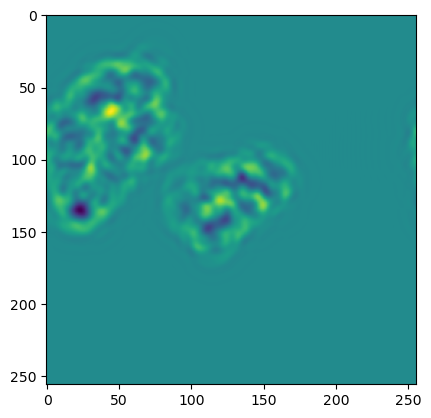

In [1909]:
plt.imshow(image_ctf)

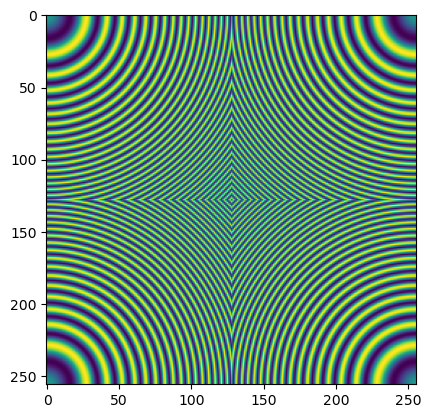

In [1910]:
plt.imshow(ctf.real)

## Add noise

In [1911]:
def circular_mask(n_pixels, radius):

    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :]**2 + grid[:, None]**2
    mask = r_2d < radius**2

    return mask


def add_noise(img, image_params):

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()

    if isinstance(image_params["SNR"], float):
        snr = image_params["SNR"]

    elif isinstance(image_params["SNR"], list) and len(image_params["SNR"]) == 2:
        snr = np.random.uniform(low=image_params["SNR"][0], high=image_params["SNR"][1])

    else:
        raise ValueError("SNR should be a single value or a list of [min_defocus, max_defocus]")

    noise_std = signal_std / np.sqrt(snr)

    img_noise = img + torch.distributions.normal.Normal(0, noise_std).sample(img.shape)

    return img_noise


def add_gradient_noise(img, image_params):

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])
    
    noise = torch.stack(
        [
            torch.distributions.normal.Normal(0, signal_std / np.sqrt(snr)).sample([img.shape[0],]) 
            for snr in np.logspace(-1, -2, img.shape[0])
        ],
        dim=1
    )
    
    img_noise = img + noise

    return img_noise


def add_colored_noise(img, image_params):
    image_L = img.shape[0]

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])
    
    img_noise = torch.distributions.normal.Normal(0, noise_std).sample(img.shape)
    fft_noise = torch.fft.fft2(img_noise)

    noise_scale = 1.5
    along_x, along_y = np.linspace(-1, 1, image_L), np.linspace(-1, 1, image_L)
    mesh_x, mesh_y = np.meshgrid(along_x, along_y)
    f = torch.zeros((image_L, image_L))

    for ix in range(image_L):
        for iy in range(image_L):
            f[ix, iy] = np.abs(mesh_x[ix, iy])**noise_scale + np.abs(mesh_y[ix, iy])**noise_scale

    t = torch.abs(torch.fft.ifft2(fft_noise / f))

    noise_scale = 1.0 / (t.max() - t.median())
    t = ((t - t.median()) * noise_scale) + 1

    img_noise = torch.distributions.normal.Normal(0, noise_std * t).sample()
    return img_noise + img


def add_shot_noise(image, image_params, noise_scale=1):

    norm_img = image - image.min()
    shot_noise = torch.poisson(norm_img * noise_scale)
    
    shot_image = norm_img * noise_scale + shot_noise

    return norm_img * noise_scale

In [1912]:
#image = add_shot_noise(image_ctf, image_params, noise_scale=1e4)
#_ = plt.imshow(image)

In [1913]:
image = add_noise(image_ctf, image_params)

In [1914]:
#image = add_colored_noise(image_ctf, image_params)

In [1915]:
#plt.imshow(add_colored_noise(image, image_params))

## Add random shift

In [1916]:
def apply_random_shift(padded_image, image_params):

    shift_x = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))
    shift_y = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width - shift_x
    high_ind_x = padded_image.shape[0] - pad_width - shift_x

    low_ind_y = pad_width - shift_y
    high_ind_y = padded_image.shape[0] - pad_width - shift_y

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image


def apply_no_shift(padded_image, image_params):

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width
    high_ind_x = padded_image.shape[0] - pad_width

    low_ind_y = pad_width
    high_ind_y = padded_image.shape[0] - pad_width

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image

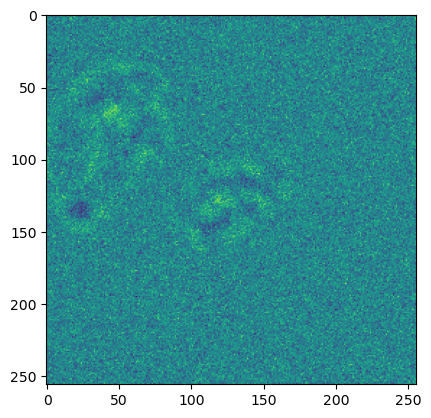

In [1917]:
#image = apply_random_shift(image, image_params)
plt.imshow(image)

## Normalize image

In [1918]:
def gaussian_normalize_image(image):

    mean_img = torch.mean(image)
    std_img = torch.std(image)

    return (image - mean_img) / std_img

image = gaussian_normalize_image(image).to(dtype=torch.float)

In [1919]:
extra_pixel = round(image_params["N_PIXELS"] * margin_ratio)
x_shift, y_shift = np.random.randint(low=-10, high=10, size=(2,))
low_x, high_x = extra_pixel // 2 + x_shift, extra_pixel // 2 + image_params["N_PIXELS"] + x_shift
low_y, high_y = extra_pixel // 2 + x_shift, extra_pixel // 2 + image_params["N_PIXELS"] + x_shift

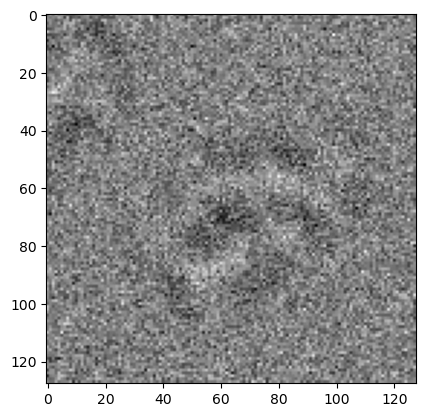

In [1920]:
#plt.imshow(image[low_x: high_x, low_y: high_y], vmax=4, vmin=-4, cmap='binary')
plt.imshow(image[low_x: high_x, low_y: high_y], vmax=4, vmin=-4, cmap='binary')

In [1921]:
from cryo_sbi.inference.models import build_models
import json
train_config = json.load(open("../experiments/benchmark_hsp90/resnet18_encoder.json"))
estimator = build_models.build_npe_flow_model(train_config)
estimator.load_state_dict(torch.load('../experiments/benchmark_hsp90/posterior_hsp90.estimator'))
estimator.cuda()
estimator.eval();

In [1922]:
from cryo_sbi.utils.estimator_utils import sample_posterior
test_image = image[low_x: high_x, low_y: high_y]
samples = sample_posterior(estimator, test_image.unsqueeze(0), num_samples=10000, device='cuda')

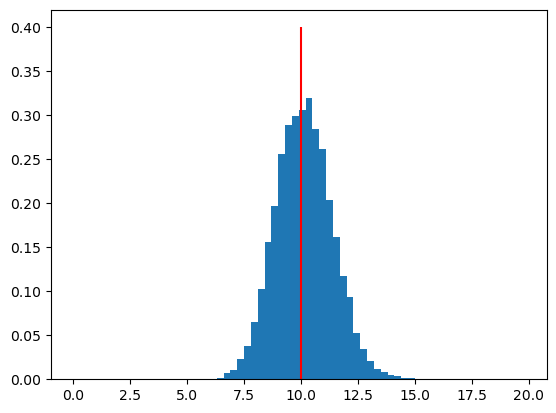

In [1923]:
_ = plt.hist(samples.flatten(), bins=np.arange(0, 20, 0.3), density=True)
_ = plt.vlines(10, 0, 0.4, color='red')

In [1533]:
import torch
import numpy as np
import json
from scipy.spatial.transform import Rotation

from cryo_sbi.wpa_simulator.ctf import calc_ctf, apply_ctf
from cryo_sbi.wpa_simulator.image_generation import gen_img, gen_quat
from cryo_sbi.wpa_simulator.noise import add_noise
from cryo_sbi.wpa_simulator.normalization import gaussian_normalize_image
from cryo_sbi.wpa_simulator.padding import pad_image
from cryo_sbi.wpa_simulator.shift import apply_no_shift, apply_random_shift
from cryo_sbi.wpa_simulator.validate_image_config import check_params


class CryoEmSimulator:
    def __init__(self, config_fname):
        self._load_params(config_fname)
        self._load_models()
        self.rot_mode = None
        self.quaternions = None
        self._config_rotations()
        self._pad_width = int(np.ceil(self.config["N_PIXELS"] * 0.1)) + 1

    def _load_params(self, config_fname):
        config = json.load(open(config_fname))
        check_params(config)
        self.config = config

    def _load_models(self):
        if "hsp90" in self.config["MODEL_FILE"]:
            self.models = np.load(self.config["MODEL_FILE"])[:, 0]

        elif "6wxb" in self.config["MODEL_FILE"]:
            self.models = np.load(self.config["MODEL_FILE"])

        elif "square" in self.config["MODEL_FILE"]:
            self.models = np.transpose(
                np.load(self.config["MODEL_FILE"]).diagonal(), [2, 0, 1]
            )
        print(self.config["MODEL_FILE"])

    def _config_rotations(self):
        if isinstance(self.config["ROTATIONS"], bool):
            if self.config["ROTATIONS"]:
                self.rot_mode = "random"

        elif isinstance(self.config["ROTATIONS"], str):
            self.rot_mode = "list"
            self.quaternions = np.loadtxt(self.config["ROTATIONS"], skiprows=1)

            assert (
                self.quaternions.shape[1] == 4
            ), "Quaternion shape is not 4. Corrupted file?"

    @property
    def max_index(self):
        return len(self.models) - 1
    
    def _gen_electron_density(self, index, quaternion):
        index = int(torch.round(index))
        coord = np.copy(self.models[index])
        if quaternion is not None:
            rot_mat = Rotation.from_quat(quaternion).as_matrix()
            coord = np.matmul(rot_mat, coord)
        return coord
    

    def _add_local_micrograp(self, num_particles):
        coords = []
        for i in range(num_particles):
            quaternion = gen_quat()
            index = torch.randint(low=0, high=self.max_index, size=(), dtype=torch.float)
            coord = self._gen_electron_density(index, quaternion)
            r = np.random.uniform(low=120, high=180)
            phi = np.random.uniform(low=0, high=2*np.pi)
            coord += np.array([r*np.cos(phi), r*np.sin(phi), 0]).reshape(-1, 1)
            coords.append(coord)
        return np.concatenate(coords, axis=1)
    

    def _gen_image_density(self, index, quaternion, num_noise_particles=None):
        main_particle = self._gen_electron_density(index, quaternion)
        if num_noise_particles is not None:
            num_noise_particles = self._add_local_micrograp(num_noise_particles)
            return np.concatenate((main_particle, num_noise_particles), axis=1)
        else:
            return main_particle

    def _simulator_with_quat(self, index, quaternion, seed):
        coord = self._gen_image_density(index, quaternion, num_noise_particles=30)

        image = gen_img(coord, self.config)
        image = pad_image(image, self.config)

        plt.imshow(image)
        plt.show()

        if self.config["CTF"]:
            image = apply_ctf(image, calc_ctf(self.config))
            plt.imshow(image)
            plt.show()

        if self.config["NOISE"]:
            image = add_noise(image, self.config, seed)
            plt.imshow(image)
            plt.show()

        if self.config["SHIFT"]:
            image = apply_random_shift(image, self.config, seed)
        else:
            image = apply_no_shift(image, self.config)

        image = gaussian_normalize_image(image)

        return image.to(dtype=torch.float)


    def simulator(self, index, seed=None):
        if self.rot_mode == "random":
            quat = gen_quat()
        elif self.rot_mode == "list":
            quat = self.quaternions[np.random.randint(0, self.quaternions.shape[0])]
        else:
            quat = None

        image = self._simulator_with_quat(index, quat, seed)

        return image

In [ ]:
sim = CryoEmSimulator('../experiments/6wxb/image_params_training.json')
sim.config['SNR'] = 0.1
#sim.config['NOISE'] = False
#sim.config['CTF'] = False

In [ ]:
plt.imshow(sim.simulator(torch.tensor(0.0)))